In [29]:
import ira
import qlearn as q
%alphalab dark

What data we have for the time being:

In [ ]:
with DataSource('databank::quotes') as ds:
    print([s for s in ds.series_list() if s.startswith('BITMEX_FU')])
#     d = ds.load_data('BITMEX:XBTUSD', '2020-08-23', '2020-08-24')

Let's take a quick look at XBT March futures, as opposite leg (spot) we'd use perpetual BitMex XBTUSD contract

In [24]:
with DataSource('databank::quotes') as ds:
    d = ds.load_data([
        'BITMEX_FUTURES:XBTH21', 
        'BITMEX:XBTUSD'
    ], '2021-03-01 00:00', '2021-03-25 23:00', timeframe='1h')
d = {k.split(':')[1]:v for k,v in d.items()}

Chart of basis (fut - spot) and 24 EMA

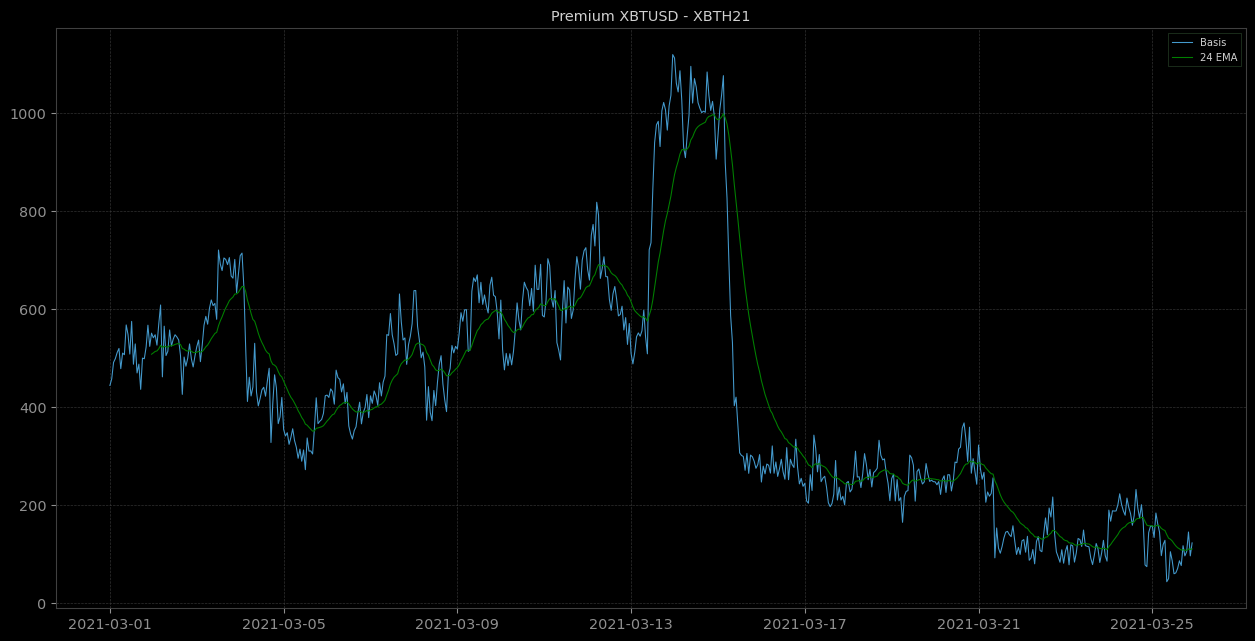

In [103]:
f1h = d['XBTH21']
p1h = d['XBTUSD']

fig(16, 8)
basis = f1h.close - p1h.close
plt.plot(basis, label='Basis')
plt.plot(apply_to_frame(ema, basis, 24), label='24 EMA')
plt.title('Premium XBTUSD - XBTH21'); plt.legend();

Now we can easy test simplest strategy: 
 - when instant basis exceeds it's average by some entry threshold we sell futures and buy spot (perpetual)
 - after instant basis drops below it's avearage by exit threshold we flat positions

In [121]:
def stupid_trading_generator(fn, sn, entry, exit, data, contracts=1000, period=24):
    fut, spot = data[fn], data[sn]
    basis = fut.close - spot.close
    eq = basis - apply_to_frame(ema, basis, period)
    entries = contracts * pd.DataFrame({fn: -1, sn: 1}, eq[(eq.shift(1) > entry) & (eq < entry)].index)
    exits = pd.DataFrame({fn:0, sn:0}, eq[(eq.shift(1) > exit) & (eq < exit)].index)
    return shift_signals(srows(entries, exits), '59Min')

We will use \\$100 as antry threshold (inst > average + 100) and -\\$80 as exit and trade fixed 5000 contracts.

In [122]:
signals = stupid_trading_generator('XBTH21', 'XBTUSD', 100, -80, d, contracts=5000, period=24) 

In [123]:
r = q.simulation(signals, d, 'crypto_futures', 'C&C', spreads=0.5)

 0: C&C  : Sharpe: 6.82 | Sortino: 82.77 | CAGR: 77.36 | DD: $15.16 (1.43%) | Gain: $56.09 | Execs: 20[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,C&C,6.821609,82.765333,77.358468,15.157787,1.432306,56.088184,20


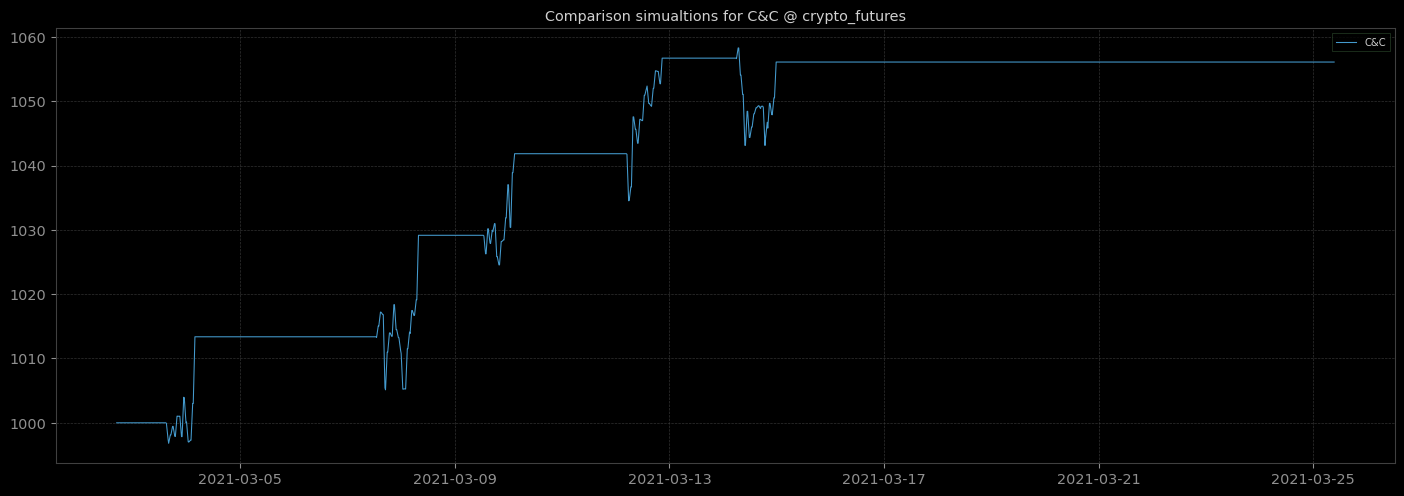

In [126]:
fig(18, 6)
r.report(1000)

And final backtest result (comissions are take in account):


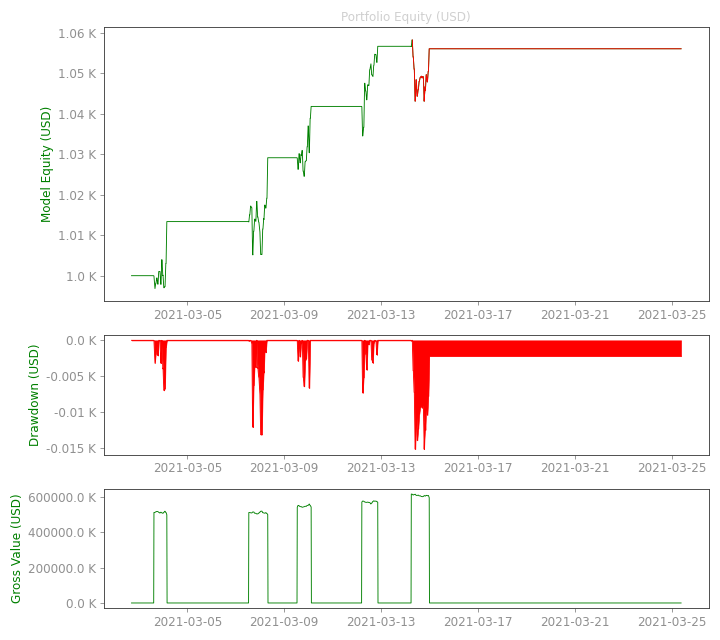

<Figure size 720x640 with 0 Axes>

In [129]:
tearsheet(r.results[0].get_portfolio(commissions=0.075), 1000)